# First break picking using semantic segmentation approach 

In this notebook, we will continue to discuss first break picking task, but now we will try to treat this task as semantic segmentation. In this case, the neural network predicts a binary mask where each sample of a trace before the first break is labeled as the no-signal one while all the samples after the first break — as signal ones.

* [Dataset](#Dataset)
* [Model architecture](#Model-Architecture)
* [Training](#Training)
* [Inference](#Inference)
* [Running time](#Running-time)
* [Model evaluation](#Model-evaluation)
* [Conclusion](#Conclusion)

In [1]:
def plot_loss(loss):
    plt.figure(figsize=(25, 6))
    plt.grid()
    plt.plot(loss)
    plt.title('Loss history during training', fontsize=16)
    plt.xlabel('Iteration', fontsize=16)
    plt.ylabel('Mean Absolute Error', fontsize=16)
    plt.show()

Define all necessery imports

In [2]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt

from seismicpro.src import SeismicDataset, Survey, MetricsMap
from seismicpro.batchflow import BA, B, V, F
from seismicpro.batchflow.models.torch import UNet, ResBlock

import warnings
warnings.filterwarnings("ignore")

%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


## Dataset

Initialize surveys and load first breaks

In [3]:
sgy_path = "survey_for_first_break_picking.sgy"
picking_path = "times_of_first_break.txt"

survey = Survey(sgy_path, header_index='FieldRecord', header_cols=['TraceNumber', 'offset'], name='raw')
survey.load_first_breaks(picking_path)

Define dataset and split the data into train and test sets

In [4]:
dataset = SeismicDataset(surveys=survey)
dataset.split(shuffle=True)

Reindex dataset by individual traces

In [5]:
dataset.reindex('TRACE_SEQUENCE_FILE', reindex_nested=True);

## Model Architecture
Specify model config, optimizer and loss function. We use UNet-based architecture consisting of two parts - encoder and decoder. Both of them are based on ResNet-like models with Concurrent Spatial and Channel Squeeze & Excitation attention blocks.

In [6]:
BATCH_SIZE = 512
N_EPOCHS = 5

model_config = {
    'body/encoder/blocks/filters': [8, 16, 32, 64],
    'body/encoder/blocks/attention': 'scse',
    'body/encoder/blocks/base': ResBlock,
    
    'body/decoder/blocks/filters': [64, 32, 16, 8],
    'body/decoder/blocks/attention': 'scse',
    'body/decoder/blocks/base': ResBlock,
    
    'body/embedding/filters': 128,
    
    'common/conv/kernel_size': 5,
    'loss': 'bce',
    'optimizer': ('Adam', {"lr": 0.001}),
    'output' : 'sigmoid'
}

## Training
Define training pipeline that contains all procedures from data loading to model training. This pipeline runs for 5 epochs.

In [7]:
train_pipeline = (dataset.train.pipeline()
    # initializing the model and auxiliary variable
    .init_variable('loss_history', [])
    .init_model('fbp_model', UNet, 'dynamic', config=model_config)
    
    # data preprocessing
    .load(src='raw', combined=True)
    .scale_standard(src='raw')
    .make_model_inputs(src=BA('raw').data, dst='inputs', expand_dims_axis=1)

    # mask preprocessing
    .pick_to_mask(src='raw')
    .make_model_inputs(src=BA('raw').mask, dst='prepared_mask', expand_dims_axis=1)
    
    # model training and loss accumulating
    .train_model('fbp_model', fetches='loss', images=B('inputs'),
                 targets=B('prepared_mask'), save_to=V('loss_history', mode='a'))
)

train_pipeline.run(BATCH_SIZE, n_epochs=N_EPOCHS, drop_last=True, shuffle=True, bar='n')

  0%|                                                                                                         …

Plot loss value over iterations

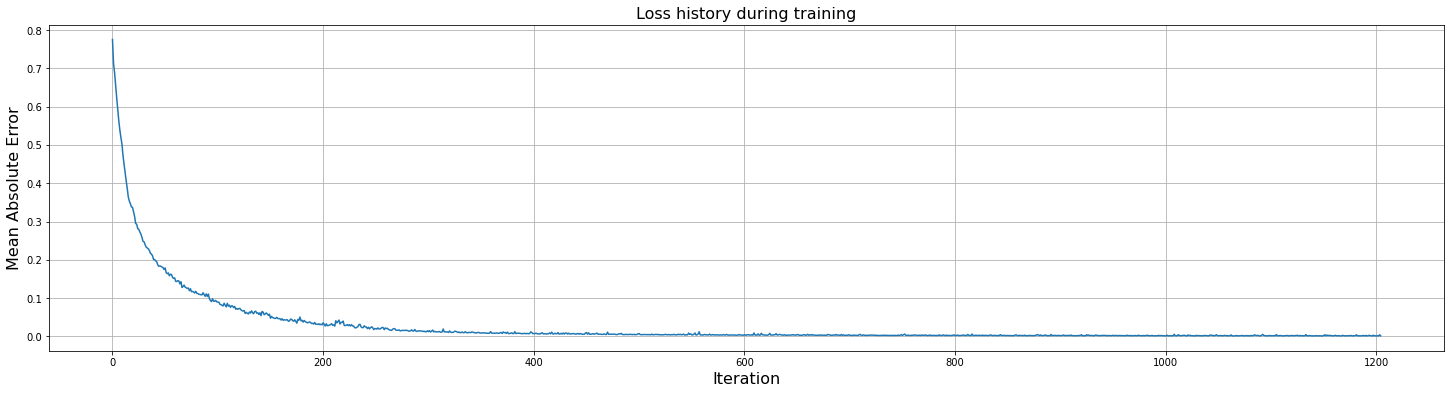

In [8]:
plot_loss(train_pipeline.v('loss_history'))

We can notice that plot value decreases during training and reaches a plateau. This indicates that the training procedure has converged.

## Inference

Measure model's quality as a module of the distance between predicted and real times of first break. To convert binary mask to picking we use ```mask_to_pick``` method that defines the first break as the beginning of the longest sequence of signal samples in a mask.

In [9]:
val_pipeline = (dataset.test.p
    # initializing the model and auxiliary variable
    .init_variable('mae', [])
    .import_model('fbp_model', train_pipeline)
    
    # loading and data preparation
    .load(src='raw', combined=True)
    .scale_standard(src='raw')
    .make_model_inputs(src=BA('raw').data, dst='inputs', expand_dims_axis=1)
    
    # model prediction
    .predict_model('fbp_model', images=B('inputs'), fetches='sigmoid', save_to=B('predicted_masks'))
    
    # result prostprocessing
    .split_model_outputs(src=B('predicted_masks')[:, 0], dst=BA('raw').predicted_masks,
                         shapes=BA('raw').shape[:, 0])
    .mask_to_pick(src='raw', dst='raw', first_breaks_col='PredictedBreak', mask_attr='predicted_masks')
                
    # collecting metric
    .update(V('mae', mode='e'), abs(BA('raw')['PredictedBreak'] - BA('raw')['FirstBreak']))
)

val_pipeline.run(BATCH_SIZE, n_epochs=1, drop_last=False, shuffle=False, bar='n')

  0%|                                                                                                         …

In [10]:
metrics = np.concatenate(val_pipeline.v('mae'))
print(f"Mean absolute error is {metrics.mean():.2f} samples")

Mean absolute error is 1.20 samples


The average distance between model prediction and true times is 5 times smaller than regression one!

## Model evaluation
Let's visualize the predictions of the model. Firstly, reindex the dataset by FieldRecord, in order to make predictions for gathers, not for traces.

In [11]:
dataset.test.index.reindex('FieldRecord', inplace=True)

Construct evaluation pipeline with a plot function in the end

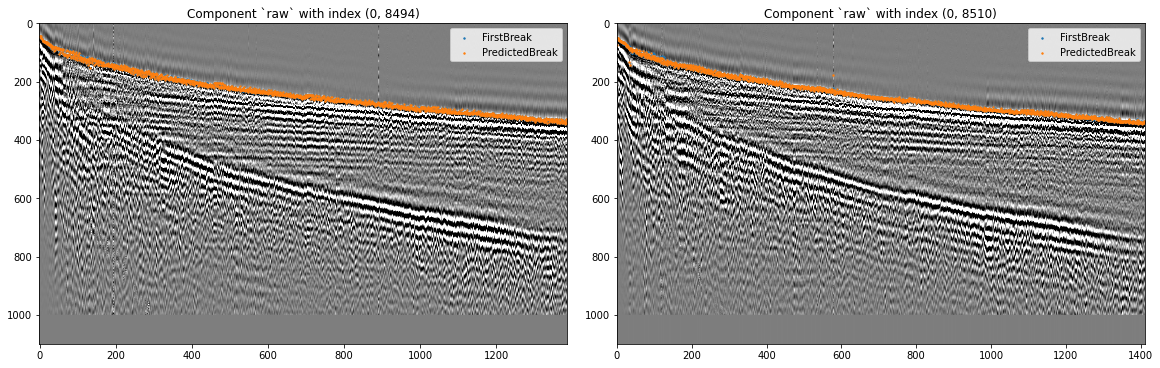

In [12]:
plot_pipeline = (dataset.test.p
    .import_model('fbp_model', train_pipeline)
    
    # loading and data preparation
    .load(src='raw')
    .scale_standard(src='raw')
    .make_model_inputs(src=BA('raw').data, dst='inputs', expand_dims_axis=1)
    
    .predict_model('fbp_model', images=B('inputs'), fetches='sigmoid', save_to=B('predicted_masks'))

    .split_model_outputs(src=B('predicted_masks')[:, 0], dst=BA('raw').predicted_masks, shapes=BA('raw').shape[:, 0])
    .mask_to_pick(src='raw', dst='raw', first_breaks_col='PredictedBreak', mask_attr='predicted_masks')
    .sort(src='raw', by='offset')
    
     .plot(src='raw', figsize=(8, 5), points=dict(col_name=['FirstBreak', 'PredictedBreak'], s=2))
    )

plot_pipeline.next_batch(2)

The examples show that model's predictions are almost identical with real labels.
### Conclusion
The model based on semantic segmentation approach proved that neural networks have a great potential for seismic processing automatization!